In [ ]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 2.0 MB/s 
     |████████████████████████████████| 9.8 MB 4.8 MB/s 
     |████████████████████████████████| 76 kB 2.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv(filepath_or_buffer="./drive/MyDrive/rob.csv")
data

,Months,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43
...,...,...
113,1975-06,316
114,1975-07,398
115,1975-08,394
116,1975-09,431


In [ ]:
data = data.dropna(axis=1, how='any')
data

,Months,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43
...,...,...
113,1975-06,316
114,1975-07,398
115,1975-08,394
116,1975-09,431


In [ ]:
data = data.set_index('Months')
data

,Robberies
Months,
1966-01,41
1966-02,39
1966-03,50
1966-04,40
1966-05,43
...,...
1975-06,316
1975-07,398
1975-08,394


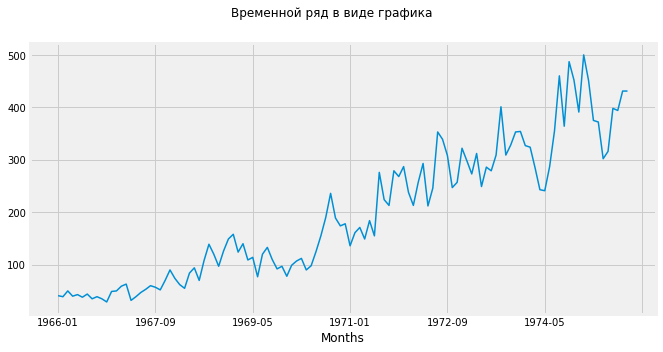

In [ ]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

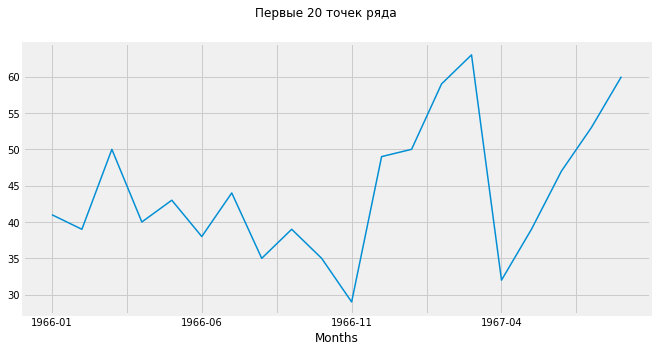

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Первые 20 точек ряда')
data[:20].plot(ax=ax, legend=False)
pyplot.show()

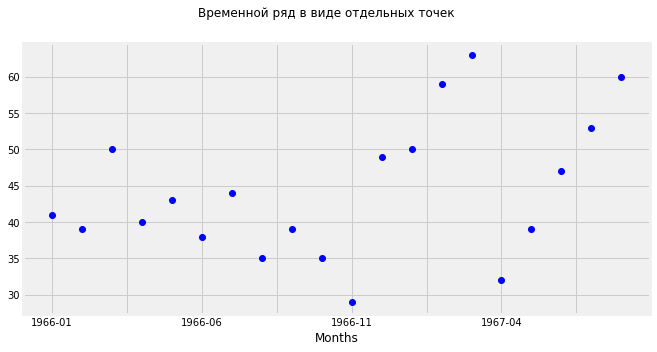

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде отдельных точек')
data[:20].plot(ax=ax, legend=False, style='bo')
pyplot.show()

         Robberies
Months            
1966-01         41
1966-02         39
1966-03         50
1966-04         40
1966-05         43
...            ...
1975-06        316
1975-07        398
1975-08        394
1975-09        431
1975-10        431

[118 rows x 1 columns]
Train dates : 1966-01 --- 1974-02  (n=98)
Test dates  : 1974-03 --- 1975-10  (n=20)


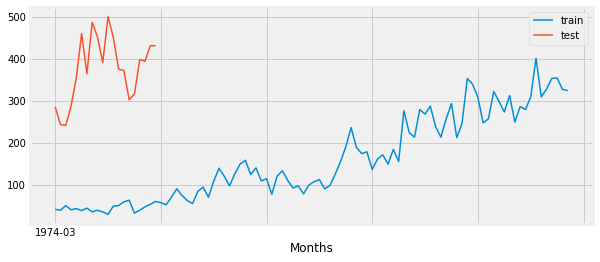

In [ ]:
import matplotlib.pyplot as plt
steps = 20
data_train = data[:-steps]
data_test  = data[-steps:]
print(data)

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Robberies'].plot(ax=ax, label='train')
data_test['Robberies'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Целочисленная метка шкалы времени 
xnum = list(range(data.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data['Robberies'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [ ]:
# Параметры модели (p,d,q) 
arima_order = (6,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [ ]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [ ]:
# Ошибка прогноза
np.mean(Y), error_arima, error_es

(196.28813559322035, 56.52075212223497, 55.21368684032806)

In [ ]:
# Записываем предсказания в DataFrame
data['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
data['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

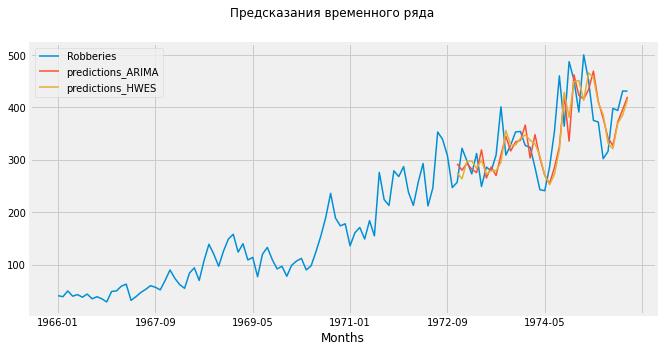

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data.plot(ax=ax, legend=True)
pyplot.show()

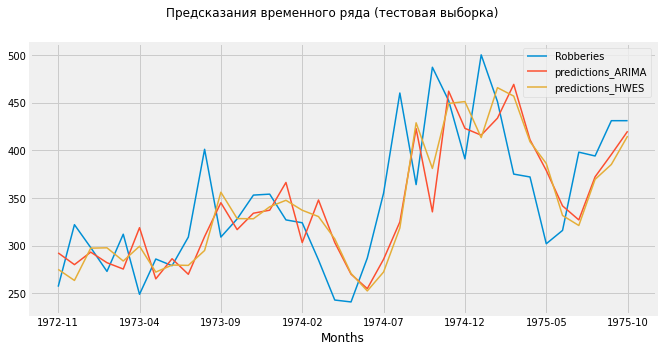

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data[train_size:].plot(ax=ax, legend=True)
pyplot.show()